In [ ]:
# first we will import the the dataset from kaggle and than visualize it

# IMports
import pandas as pd # for Data

# For viaualisation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# for time stamps
from datetime import datetime as dt

In [ ]:
# import data from yfinance
import yfinance as yf

# list of the companies
company_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# set the time frame
end_date = dt.today()
start_date = dt(end_date.year-10, end_date.month , end_date.day)

# get the data
data = yf.download(company_list, start=start_date, end=end_date)


[*********************100%***********************]  4 of 4 completed


In [ ]:
# took only apple data
apple_data = data.xs('AAPL', level='Ticker', axis=1)

# convert this raw data to a dataframe
df = pd.DataFrame(apple_data)
df.head()

Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2014-10-06 00:00:00+00:00,22.113323,24.905001,25.162500,24.855000,24.987499,148204800
2014-10-07 00:00:00+00:00,21.920212,24.687500,25.030001,24.682501,24.857500,168376800
2014-10-08 00:00:00+00:00,22.375267,25.200001,25.277500,24.577499,24.690001,229618800
2014-10-09 00:00:00+00:00,22.424101,25.254999,25.594999,25.152500,25.385000,309506000
2014-10-10 00:00:00+00:00,22.359728,25.182501,25.507500,25.075001,25.172501,265326400


In [ ]:
len(df)

2517

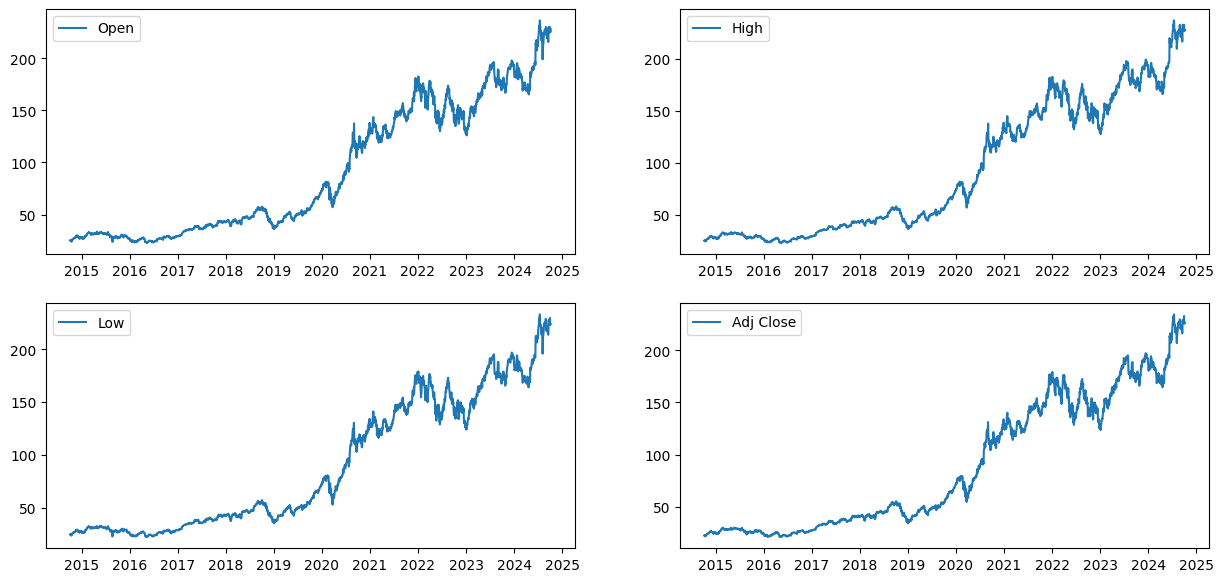

In [ ]:
# visualise the amazon all in 4 subplotes
plt.figure(figsize=(15,7))

plt.subplot(2,2,1)
plt.plot(df['Open'], label='Open')
plt.legend()

plt.subplot(2,2,2)
plt.plot((df['High']), label='High')
plt.legend()

plt.subplot(2,2,3)
plt.plot((df['Low']), label='Low')
plt.legend()

plt.subplot(2,2,4)
plt.plot((df['Adj Close']), label='Adj Close')
plt.legend()

In [ ]:
# the moving average for past 25 ,10 ,15 days

def Plot_Moving_Average(data, lag):
    plt.figure(figsize=(10,7))
    plt.plot(data, label='Data' ,linewidth=3)
    for i in range(len(lag)):
        plt.plot(data.rolling(lag[i]).mean(), label=f"{lag[i]} Days")
    plt.legend()
    plt.title(f"Moving Average for different days for '{data.name}'")
    plt.show()

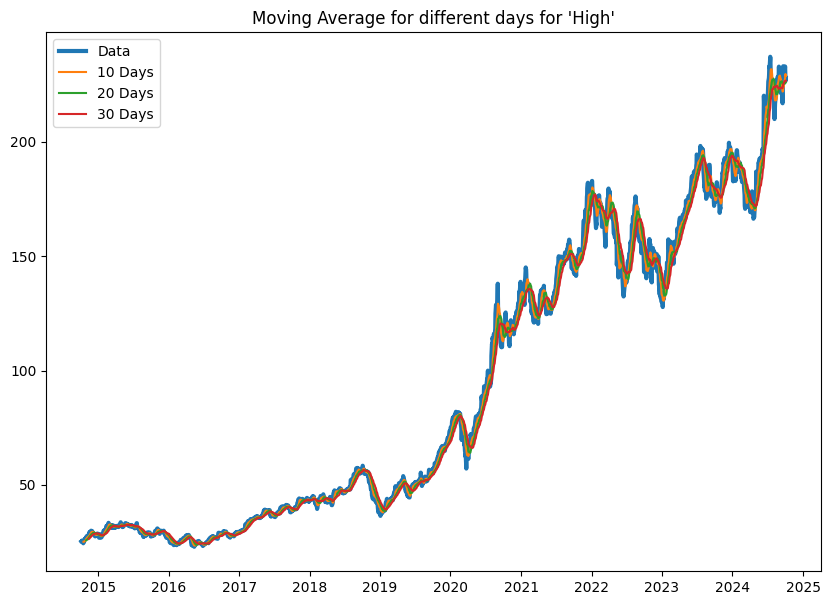

In [ ]:
Plot_Moving_Average(apple_data['High'],[10,20,30])

<h1> ARIMA


In [ ]:
''' The procedure to follow
    1. Make the Series Stationary
    2. Identify AR and MA Terms
    3. Estimate Model Parameters
    4. Diagnostic Checking
    5. Forecasting
    6. Evaluation
'''

' The procedure to follow\n    1. Make the Series Stationary\n    2. Identify AR and MA Terms\n    3. Estimate Model Parameters\n    4. Diagnostic Checking\n    5. Forecasting\n    6. Evaluation\n'

<h2> Make the series stationry

In [ ]:
# first check is the series is already stationaty
from statsmodels.tsa.stattools import adfuller

def stationaryity_check(series):
    # iterazate though all the columns
    return adfuller(series)[1]

In [ ]:
d = 0
p = stationaryity_check(apple_data['Open'].dropna())
print(p)
open_data = apple_data['Open']  # Keep original data separate
while p > 0.05:
    open_data = open_data.diff().dropna()  # Apply diff to the separate data
    p = stationaryity_check(open_data)
    d += 1


0.9866246492932558


In [ ]:
p
d

1

In [ ]:
# now split he data
from sklearn.model_selection import train_test_split
train, test = train_test_split(open_data, test_size=0.2, shuffle=False)
train.index = pd.date_range(start=train.index[0], periods=len(train), freq='D')
test.index = pd.date_range(start=test.index[0], periods=len(test), freq='D')

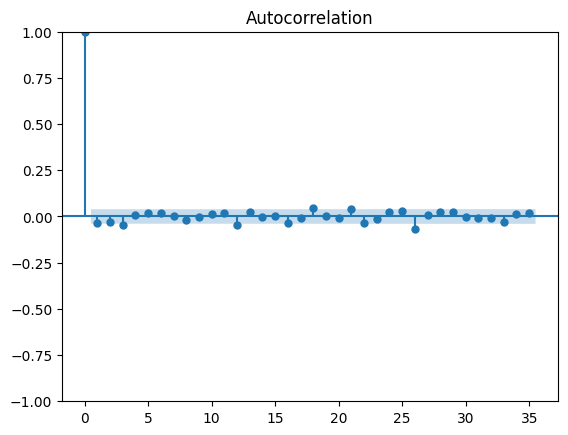

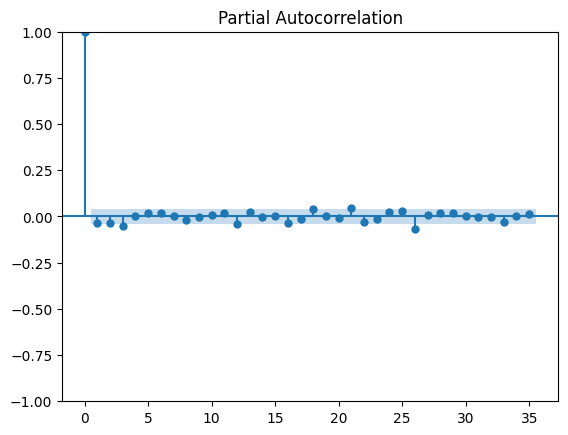

In [ ]:
# plot ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
while(d):
    series_diff = apple_data['Open'].diff().dropna()
    d-=1
plot_acf(series_diff)
plot_pacf(series_diff)
plt.show()

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
from scipy.signal import find_peaks

# Compute ACF and PACF values
acf_values = acf(series_diff, nlags=30)
pacf_values = pacf(series_diff, nlags=30)

# Find significant peaks in ACF (for q)
q_peaks, _ = find_peaks(acf_values, height=0)  # Find positive peaks
q = q_peaks[0] if len(q_peaks) > 0 else 0  # First significant lag

# Find significant peaks in PACF (for p)
p_peaks, _ = find_peaks(pacf_values, height=0)  # Find positive peaks
p = p_peaks[0] if len(p_peaks) > 0 else 0  # First significant lag

print(f"Selected p: {p}, Selected q: {q}")

Selected p: 5, Selected q: 5


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train['Open'], order=(5, 1, 5))  # Replace p, d, q with chosen values
model_fit = model.fit()

# 6. Summary of the model
print(model_fit.summary())

# 7. Forecast
forecast = model_fit.forecast(steps = len(test))

print(forecast)

# 8. Plot forecast
#series.plot(label='Historical')
#forecast.plot(label='Forecast', color='red')

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                 2013
Model:                 ARIMA(5, 1, 5)   Log Likelihood               -3939.216
Date:                Sat, 05 Oct 2024   AIC                           7900.432
Time:                        11:16:35   BIC                           7962.107
Sample:                    10-06-2014   HQIC                          7923.071
                         - 04-09-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1604      0.185      0.866      0.387      -0.203       0.524
ar.L2          0.2269      0.136      1.671      0.095      -0.039       0.493
ar.L3         -0.5744      0.087     -6.604      0.0

In [ ]:
forecast = forecast.to_frame()
forecast.head()

,predicted_mean
2020-04-10 00:00:00+00:00,138.462286
2020-04-11 00:00:00+00:00,138.997450
2020-04-12 00:00:00+00:00,138.989522
2020-04-13 00:00:00+00:00,138.960276
2020-04-14 00:00:00+00:00,138.908222


In [ ]:
test.head()

Price,Adj Close,Close,High,Low,Open,Volume
2022-10-04 00:00:00+00:00,144.498978,146.100006,146.220001,144.259995,145.029999,87830100
2022-10-05 00:00:00+00:00,144.795670,146.399994,147.380005,143.009995,144.070007,79471000
2022-10-06 00:00:00+00:00,143.836304,145.429993,147.539993,145.220001,145.809998,68402200
2022-10-07 00:00:00+00:00,138.554825,140.089996,143.100006,139.449997,142.539993,85925600
2022-10-08 00:00:00+00:00,138.881226,140.419998,141.889999,138.570007,140.419998,74899000


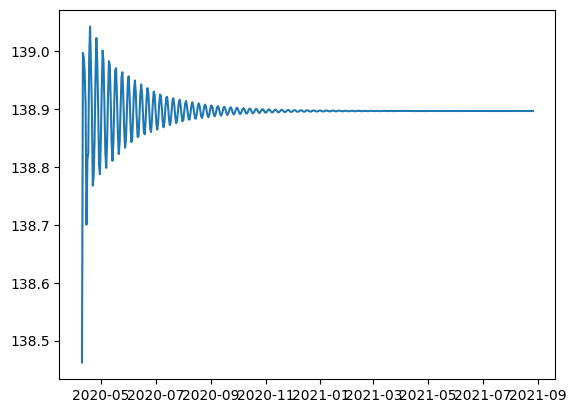

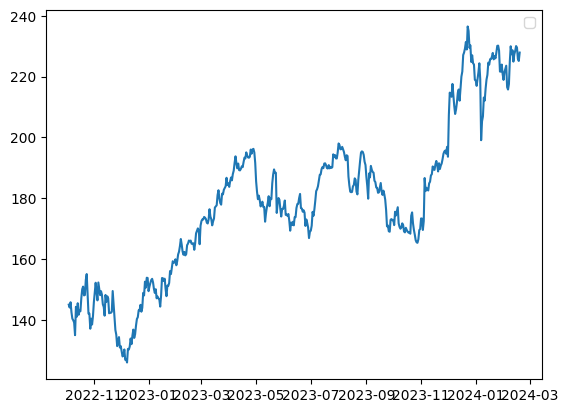

In [ ]:
plt.plot(forecast)
plt.show()
plt.plot(test['Open'])
plt.legend()
#plt.xlim(2013,2017)
plt.show()